## Import libraries

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

## Reading the image

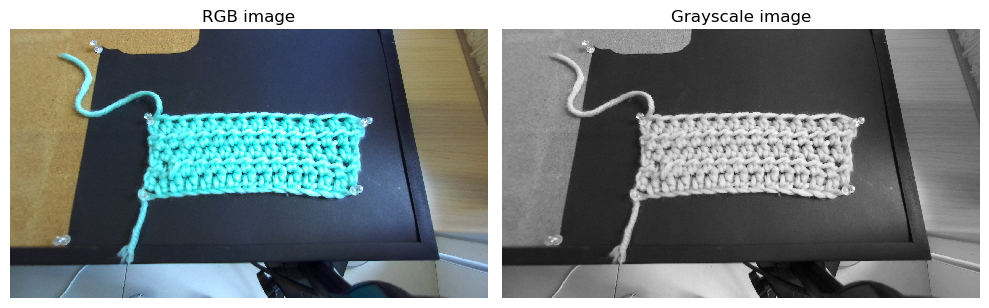

In [2]:
lana = 'prueba2.png'
img = cv.imread(lana, cv.IMREAD_COLOR)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.imread(lana, cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img_rgb)
ax[0].axis('off')
ax[0].set_title('RGB image')

ax[1].imshow(img_gray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Grayscale image')

fig.tight_layout()
plt.show()

## Looking at every RGB channel

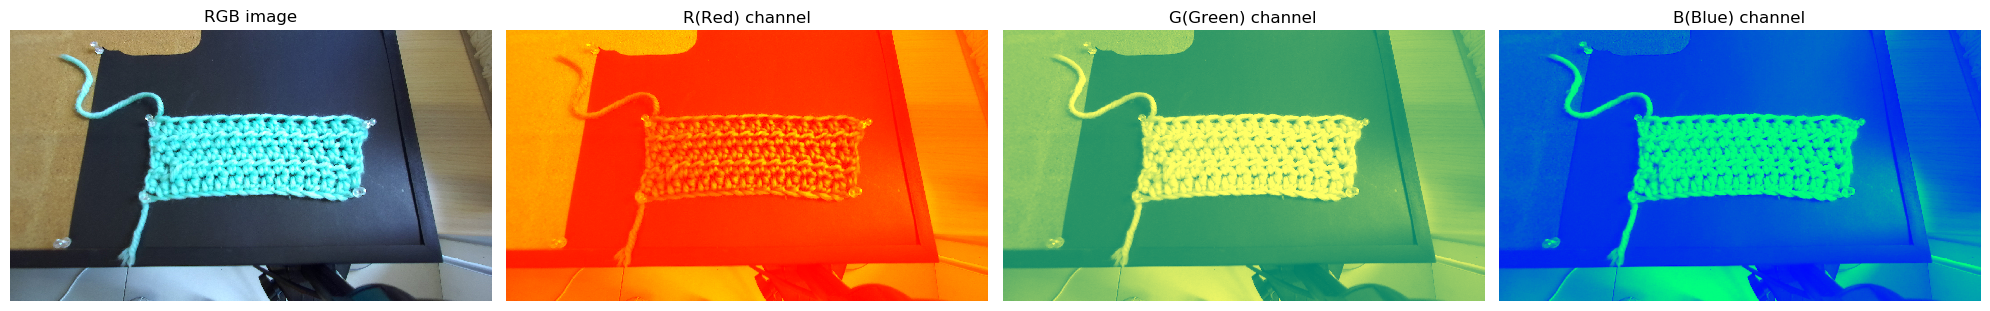

In [3]:
fig, ax = plt.subplots(1,4,figsize=(20,4))

ax[0].imshow(img_rgb)
ax[0].axis('off')
ax[0].set_title('RGB image')

ax[1].imshow(img_rgb[:,:,0],cmap='autumn')
ax[1].axis('off')
ax[1].set_title('R(Red) channel')

ax[2].imshow(img_rgb[:,:,1],cmap='summer')
ax[2].axis('off')
ax[2].set_title('G(Green) channel')

ax[3].imshow(img_rgb[:,:,2],cmap='winter')
ax[3].axis('off')
ax[3].set_title('B(Blue) channel')

fig.tight_layout()
plt.show()

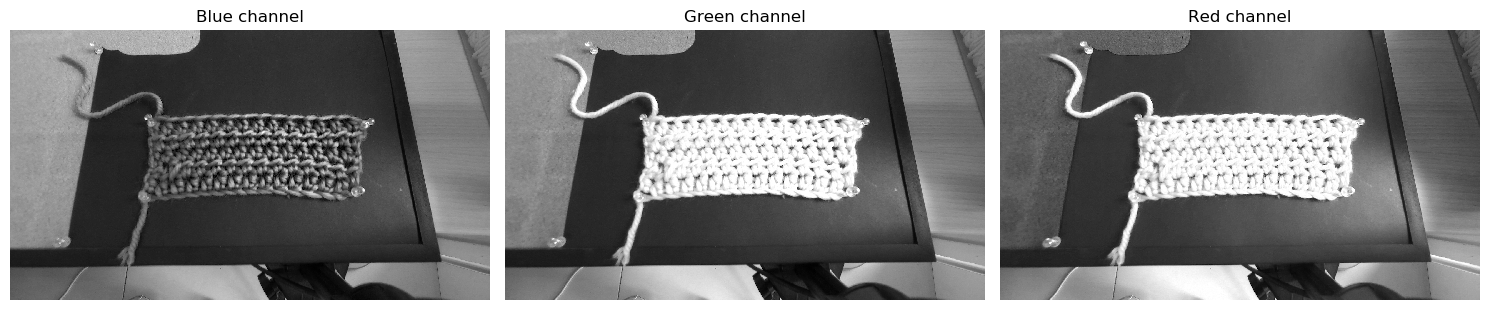

In [4]:
(B, G, R) = cv.split(img_rgb)
cv.imwrite("blue.png", B)
cv.imwrite("green.png", G)
cv.imwrite("red.png", R)

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(B, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Blue channel')

ax[1].imshow(G, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Green channel')

ax[2].imshow(R, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Red channel')

fig.tight_layout()
plt.show()

## Plotting the Histogram

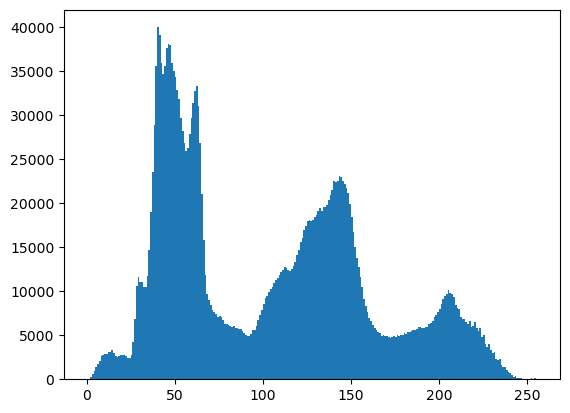

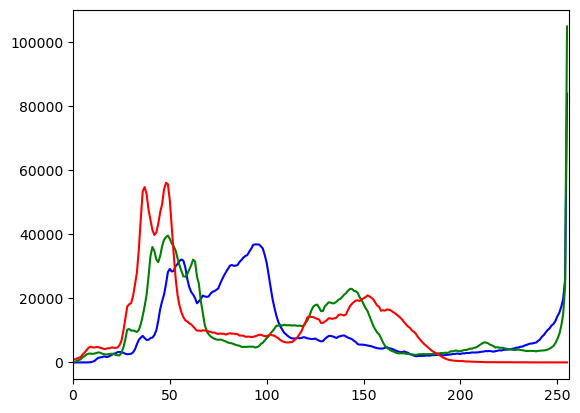

In [5]:
hist = cv.calcHist([img_gray],[0],None,[256],[0,256]) # img
plt.hist(img_gray.ravel(),256,[0,256])
plt.show()

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

## Histogram Equalization

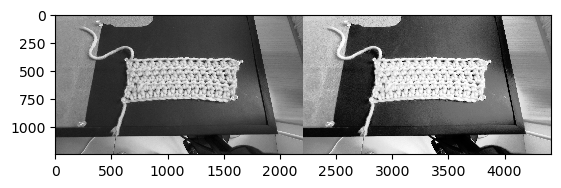

In [6]:
equ = cv.equalizeHist(img_gray)
res = np.hstack((img_gray,equ))
plt.imshow(res, cmap='gray')

## CLAHE (Contrast Limited Adaptive Histogram Equalization)

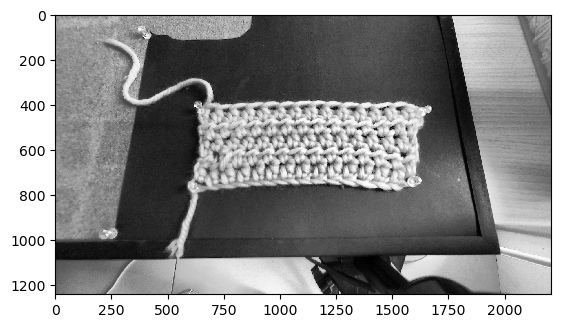

In [7]:
# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
cl1 = clahe.apply(img_gray)
plt.imshow(cl1, cmap='gray')

## Thresholding

Using grayscale images as they have a higher contrast with the background

cv.threshold returns the threshold and the thresholded img
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

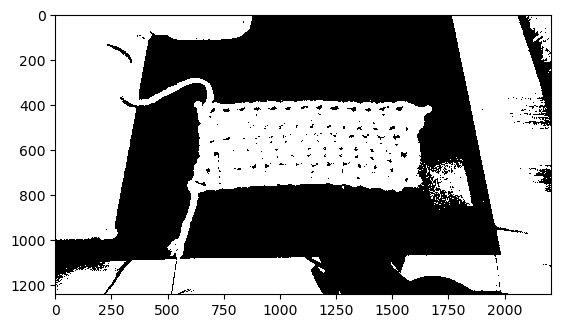

In [8]:
ret,th1 = cv.threshold(equ,127,255,cv.THRESH_BINARY)
plt.imshow(th1, cmap='gray')

### OTSU Thresholding

Tried with the grayscale image, the equalized histogram image and the clahe. Best results are obtained when using the equalized histogram.

128.0


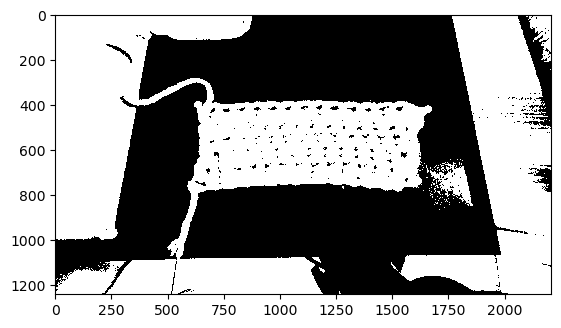

In [9]:
ret2,th2 = cv.threshold(equ,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
print(ret2)
plt.imshow(th2, cmap='gray')
# cv.imwrite('otsu_equ.jpg', ret2)

### OTSU's Thresholding after Gaussian filtering

Worse results as there is more noise inside the object.

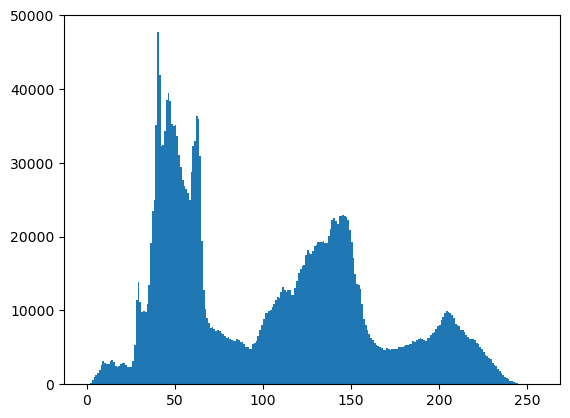

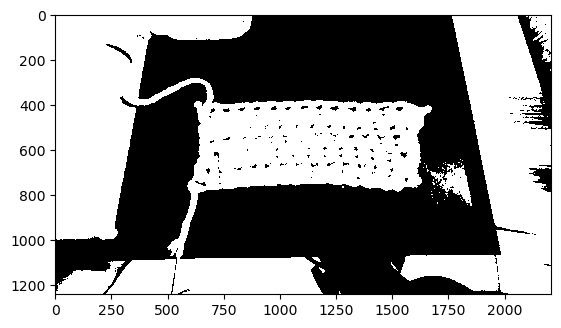

In [10]:
blur = cv.GaussianBlur(img_gray,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.hist(blur.ravel(),256,[0,256]); plt.show()
plt.imshow(th3, cmap='gray')

## Drawing the contours

Tried with the different thresholds: th1, th2, th3

When using th1 or th2, the contour includes the light comming from the top left of the image

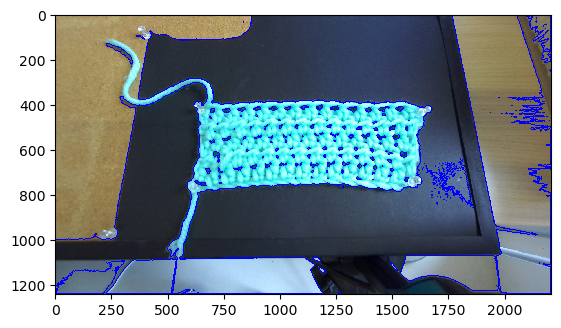

In [11]:
contours, hierarchy = cv.findContours(th3, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
cv.drawContours(img_rgb, contours, -1, (0,0,255), 3)
# cv.imwrite('contours.jpg',img_rgb)
plt.imshow(img_rgb)

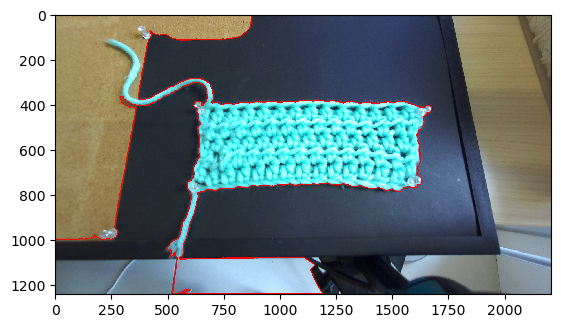

In [12]:
## Finding the biggest contour
def getBiggestContour(contours):
    biggestArea = 0
    for cnt in contours:
        area = cv.contourArea(cnt)
        if biggestArea < area:
            biggestArea = area
            biggestContour = cnt
    return biggestContour, biggestArea

img = cv.imread(lana, cv.IMREAD_COLOR)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
biggestContour, biggestArea = getBiggestContour(contours)
cv.drawContours(img_rgb, biggestContour, -1, (255,0,0), 3)
# cv.imwrite('biggestContour.jpg',img_rgb)
plt.imshow(img_rgb)

## Bounding Rectangle

The ROI is disturbed by the tails of the yarn.

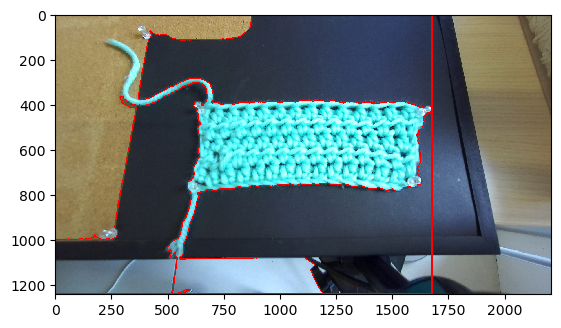

In [13]:
x,y,w,h = cv.boundingRect(biggestContour)
cv.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),8)
plt.imshow(img_rgb)

## Morphological Transformations

https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

1. Closing: To get rid of the noise inside the yarn (the holes)
2. Opening: To get rid of the noise outside the yarn (the tails)

After trying with different combinations, I've concluded that a smaller kernel with a higher number of iterationsgives the best results for this concrete image.

First of all I'm doing the dilation and erosion to see the steps inside the closing and opening

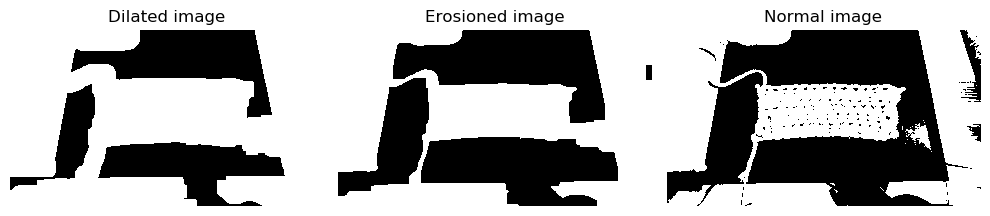

In [14]:
kernel = np.ones((5,5),np.uint8)

# Dilation
dilation = cv.dilate(th3, kernel, iterations = 20)

# Erosion
erosion = cv.erode(dilation, kernel, iterations = 20)

fig, ax = plt.subplots(1,3,figsize=(10,4))

ax[0].imshow(dilation, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Dilated image')

ax[1].imshow(erosion, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Erosioned image')

ax[2].imshow(th3, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Normal image')

fig.tight_layout()
plt.show()


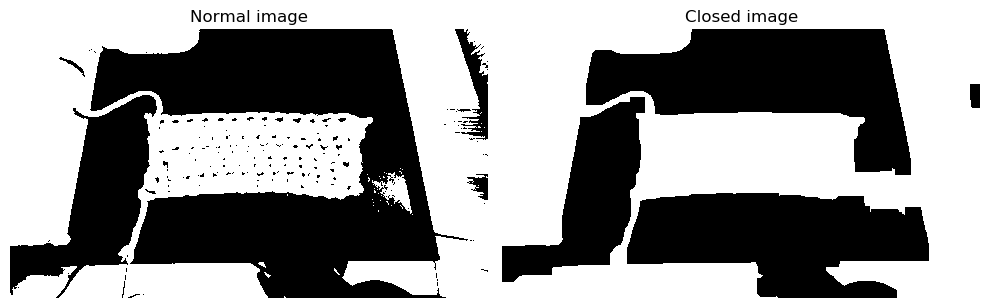

In [15]:
# Closing -> Erasing the holes inside the object
closing = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel, iterations = 18)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(th3, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Normal image')

ax[1].imshow(closing, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Closed image')

fig.tight_layout()
plt.show()

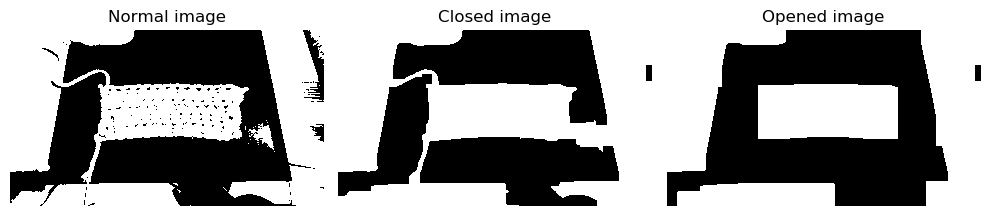

In [16]:
# Opening -> Erasing the tails
kernel = np.ones((13,13),np.uint8)

opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel, iterations = 15)

fig, ax = plt.subplots(1,3,figsize=(10,4))

ax[0].imshow(th3, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Normal image')

ax[1].imshow(closing, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Closed image')

ax[2].imshow(opening, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Opened image')

fig.tight_layout()
#plt.savefig('13_15_Opening.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

## Finding the Region of Interest
https://stackoverflow.com/questions/61541559/finding-the-contour-closest-to-image-center-in-opencv2

https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html

https://likegeeks.com/python-image-processing/#Centroid_Center_of_blob_detection

164540.0
368797.5
419265.5
390640.0


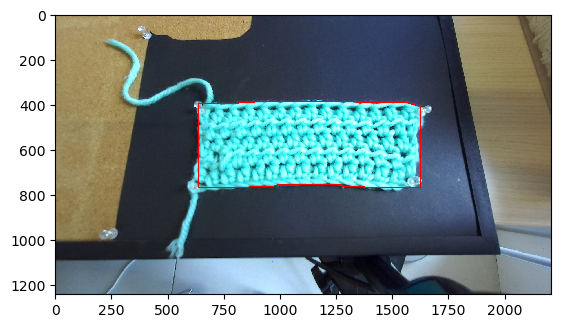

In [23]:
def euclideanDistance(p1, p2):
    # p1, p2 as tuples
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

## Finding the contour closest to the center of the image
def getCenteredContour(contours, image_center):
    minDistance = float("inf") ## Highest number 

    for cnt in contours:
        print(cv.contourArea(cnt))
        # Find the center of each contour
        M = cv.moments(cnt)
        centerX = int(M["m10"] / M["m00"])
        centerY = int(M["m01"] / M["m00"])
        contour_center = (centerX, centerY)

        # Then calculate the distance between the center of the contour and the center of the image
        distance = euclideanDistance(image_center, contour_center)
        if(distance < minDistance):
            minDistance = distance
            minDistanceContour = cnt
    return minDistanceContour


img = cv.imread(lana, cv.IMREAD_COLOR)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

## Finding the center of the image
moment = cv.moments(img_gray)
x = int(moment ["m10"] / moment["m00"])
y = int(moment ["m01"] / moment["m00"])
image_center = (x,y)
cv.circle(img_rgb, image_center, 3, (255, 100, 0), 2)

## Finding the biggest contour -> the ROI

biggestContour, biggestArea = getBiggestContour(contours)
#cv.drawContours(img_rgb, biggestContour, -1, (255,0,0), 3)

mostCenteredContour = getCenteredContour(contours, image_center)
cv.drawContours(img_rgb, mostCenteredContour, -1, (255,0,0), 3)

plt.imshow(img_rgb)

## Bounding Rectangle

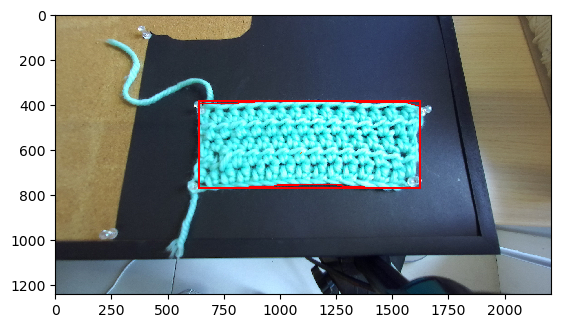

In [24]:
x,y,w,h = cv.boundingRect(mostCenteredContour)
cv.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),8)
plt.imshow(img_rgb)

## Cropping the image

[640, 386, 986, 386]


True

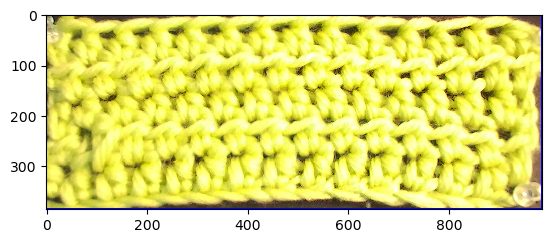

In [25]:
img = cv.imread(lana)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
dst = cv.Canny(gray, 0, 150)
blured = cv.blur(dst, (5,5), 0)    
MIN_CONTOUR_AREA=200
img_thresh = cv.adaptiveThreshold(blured, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)

[X, Y, W, H] = cv.boundingRect(mostCenteredContour)
box=cv.rectangle(img, (X, Y), (X + W, Y + H), (0,0,255), 2)

cropped_image = img[Y:Y+H, X:X+W]
print([X,Y,W,H])
plt.imshow(cropped_image)
cv.imwrite('cropped.png', cropped_image) # DO NOT ERASE

## Segundo Preprocesamiento

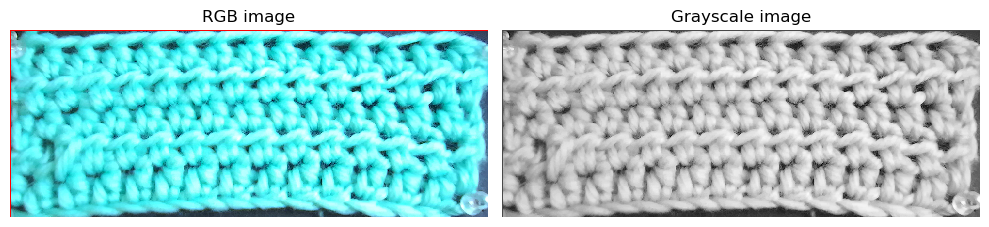

In [26]:
cropped = 'cropped.png'
img = cv.imread(cropped, cv.IMREAD_COLOR)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.imread(cropped, cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img_rgb)
ax[0].axis('off')
ax[0].set_title('RGB image')

ax[1].imshow(img_gray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Grayscale image')

fig.tight_layout()
plt.show()


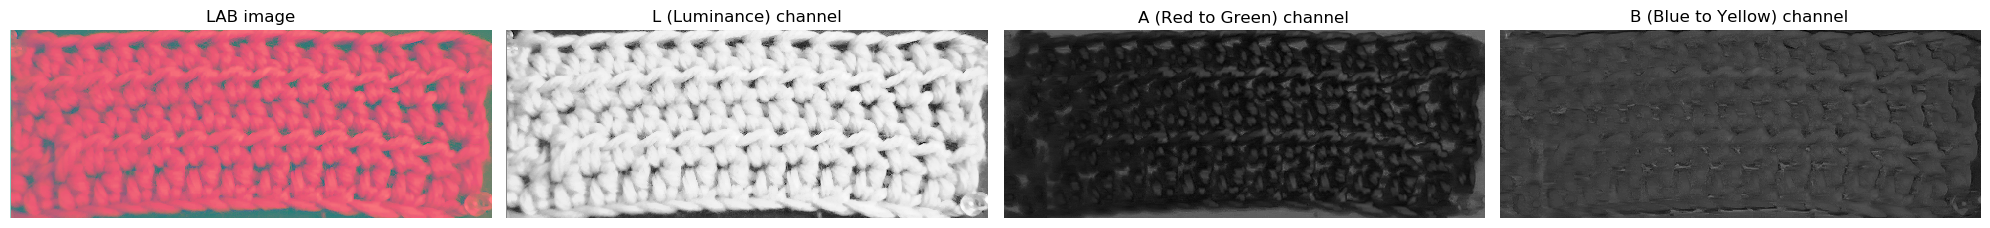

In [27]:
img_lab = cv.cvtColor(cropped_image, cv.COLOR_BGR2LAB)

fig, ax = plt.subplots(1,4,figsize=(20,4))

ax[0].imshow(img_lab,cmap='gray')
ax[0].axis('off')
ax[0].set_title('LAB image')

ax[1].imshow(img_lab[:,:,0],cmap='gray')
ax[1].axis('off')
ax[1].set_title('L (Luminance) channel')

ax[2].imshow(img_lab[:,:,1],cmap='gray')
ax[2].axis('off')
ax[2].set_title('A (Red to Green) channel')

ax[3].imshow(img_lab[:,:,2],cmap='gray')
ax[3].axis('off')
ax[3].set_title('B (Blue to Yellow) channel')

fig.tight_layout()
plt.show()

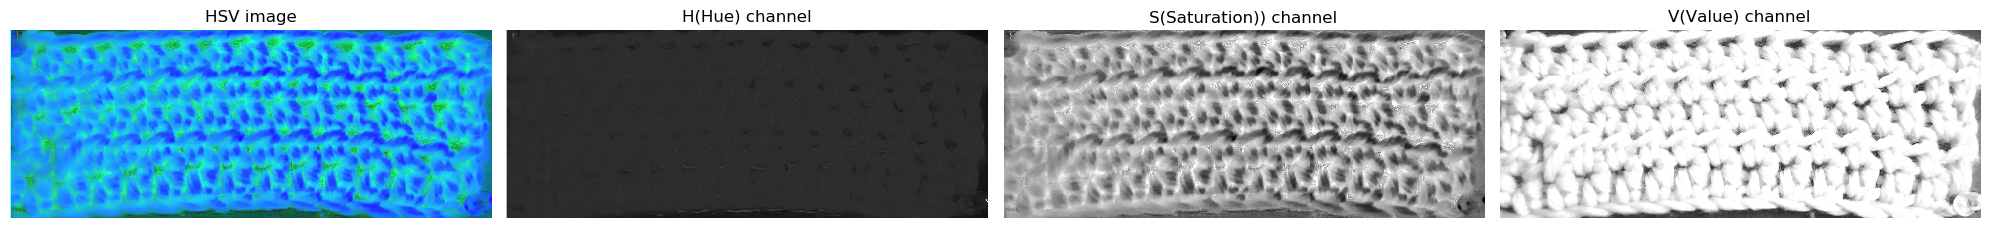

In [28]:
img_hsv = cv.cvtColor(cropped_image, cv.COLOR_RGB2HSV)

fig, ax = plt.subplots(1,4,figsize=(20,4))

ax[0].imshow(img_hsv)
ax[0].axis('off')
ax[0].set_title('HSV image')

ax[1].imshow(img_hsv[:,:,0],cmap='gray')
ax[1].axis('off')
ax[1].set_title('H(Hue) channel')

ax[2].imshow(img_hsv[:,:,1],cmap='gray')
ax[2].axis('off')
ax[2].set_title('S(Saturation)) channel')

ax[3].imshow(img_hsv[:,:,2],cmap='gray')
ax[3].axis('off')
ax[3].set_title('V(Value) channel')

fig.tight_layout()
plt.show()

## Working with the Value channel
In this example, it's the one with a higher contrast between the object and the background

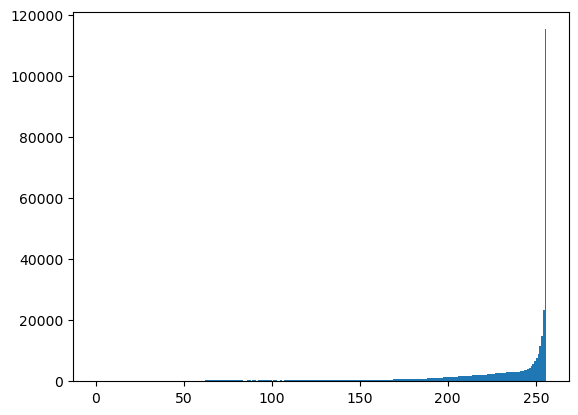

In [29]:
# Histogram
value = img_hsv[:,:,2]

hist = cv.calcHist([value],[0],None,[256],[0,256])
plt.hist(value.ravel(),256,[0,256]); plt.show()

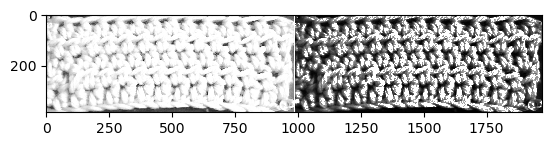

In [30]:
# Histogram Equalization
equ = cv.equalizeHist(value)
res = np.hstack((value,equ)) #stacking images side-by-side
plt.imshow(res, cmap='gray')
#cv.imwrite('hist_eq.jpg', res)

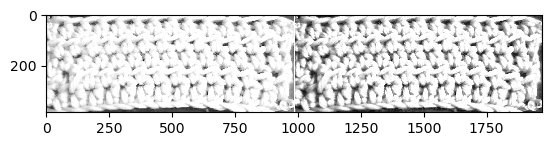

In [31]:
# CLAHE
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
cl = clahe.apply(value)
res = np.hstack((value,cl)) #stacking images side-by-side
plt.imshow(res, cmap='gray')
#cv.imwrite('clahe.jpg',res)

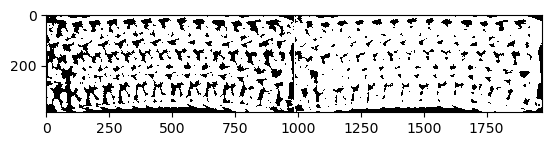

In [32]:
# OTSU Thresholding
ret1,th1 = cv.threshold(cl,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret2,th2 = cv.threshold(value,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

res = np.hstack((th1,th2)) #stacking images side-by-side
plt.imshow(res, cmap='gray')

As we can see int he image above, when converting to a binary image, the results are best without normalizing the histogram (left)

## Getting the first row
In thsi example, the 80% of the bottom of the ROI is erased

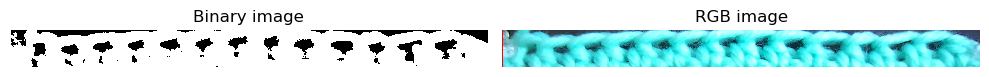

True

In [33]:
def crop_img(img, scale=1.0):
    center_y = img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    top_y, bottom_y = 0, height_scaled
    img_cropped = img[int(top_y):int(bottom_y)]
    return img_cropped

img_cropped = crop_img(th2, 0.20)
rgb_cropped = crop_img(img_rgb, 0.20)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img_cropped, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Binary image')

ax[1].imshow(rgb_cropped)
ax[1].axis('off')
ax[1].set_title('RGB image')

fig.tight_layout()
plt.show()

cv.imwrite('cropped.jpg',img_cropped) # DO NOT ERASE

## Erasing the noise inside the object (Closing)

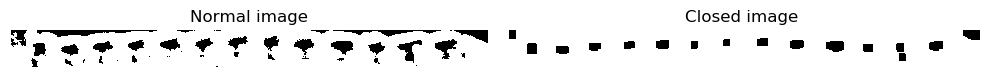

True

In [34]:
# Closing
kernel = np.ones((5,5),np.uint8)

closing = cv.morphologyEx(img_cropped, cv.MORPH_CLOSE, kernel, iterations = 3)

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img_cropped, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Normal image')

ax[1].imshow(closing, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Closed image')

fig.tight_layout()
plt.show()
cv.imwrite('closed.jpg',closing) #Se guarda para poder mostrar luego los contornos 

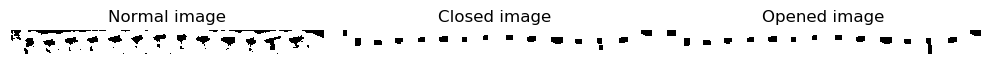

True

In [35]:
# Opening
kernel = np.ones((5,5),np.uint8)

opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel, iterations = 9)

fig, ax = plt.subplots(1,3,figsize=(10,4))

ax[0].imshow(img_cropped, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Normal image')

ax[1].imshow(closing, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Closed image')

ax[2].imshow(opening, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Opened image')

fig.tight_layout()
plt.show()
cv.imwrite('opened.jpg',opening) #Se guarda para poder mostrar luego los contornos 

## Finding the holes
Once again, by looking for the contours in the image. We don't need to worry about the background or the yanr itself being a contour, since we will erase all the outliers in the next step

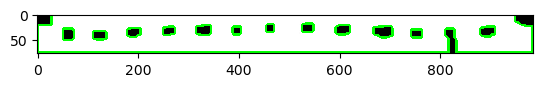

In [36]:
img = cv.imread('opened.jpg', cv.IMREAD_COLOR)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
cv.drawContours(img_rgb, contours, -1, (0,255,0), 3)
cv.imwrite('holes.jpg',img_rgb)
plt.imshow(img_rgb)

## Removing the outliers

https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html

[72807.0, 437.5, 345.5, 492.0, 436.0, 528.5, 263.5, 369.5, 756.5, 507.0, 526.5, 250.0, 382.0]
[437.5, 345.5, 492.0, 436.0, 528.5, 263.5, 369.5, 756.5, 507.0, 526.5, 250.0, 382.0]


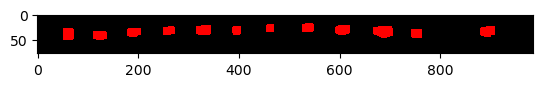

In [38]:
mask = np.zeros(img.shape,np.uint8)

def reject_outliers(areas):
    elements = np.array(areas)

    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)

    final_list = [x for x in areas if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    return final_list

areas = []
for cnt in contours:
    area = cv.contourArea(cnt)
    areas.append(area)

print(areas)
selected_areas = reject_outliers(np.array(areas))
print(selected_areas)

for cnt in contours: 
    if cv.contourArea(cnt) in selected_areas:
        cv.drawContours(mask,[cnt],0,255,-1)

"""     if area>1500 and area<10000:
        cnt_selected.append(cnt)
        cv.drawContours(mask,[cnt],0,255,-1) """
    
plt.imshow(mask)